## Final Pipeline

###**Encoder and Decoder with  Attention machanisam**

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        self.enc_units=lstm_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_size
        self.input_length = input_length
        self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, 
                                 input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder",weights=[Encoder_embedding_matrix])
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,states):
        embedding= self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c= self.lstm(embedding, initial_state = states)
      
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
   
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return tf.zeros((batch_size, self.enc_units)),tf.zeros((batch_size, self.enc_units))
      

In [ ]:
class Attention(tf.keras.layers.Layer):

  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    super(Attention, self).__init__()

    self.scoring_function=scoring_function

    # Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      self.dense = tf.keras.layers.Dense(att_units)

      # Intialize variables needed for General score function here
      pass
    elif scoring_function == 'concat':

      self.dense = tf.keras.layers.Dense(att_units, activation='tanh')
      self.dense1 = tf.keras.layers.Dense(1)

      # Intialize variables needed for Concat score function here
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):

    if self.scoring_function == 'dot':
        decoder_hidden_state=tf.expand_dims(decoder_hidden_state, 1)
        score = tf.matmul(decoder_hidden_state,encoder_output,transpose_b=True)
        attention_weights = tf.keras.activations.softmax(score, axis=-1) 
        context_vector = tf.matmul(attention_weights, encoder_output)
    
        context_vector=tf.reduce_sum(context_vector, axis=1)
      
        attention_weights=tf.reduce_sum(attention_weights, axis=1)
        attention_weights=tf.expand_dims(attention_weights, 1)
    
        return context_vector,attention_weights

        # Implement Dot score function here
        pass

    elif self.scoring_function == 'general':
        decoder_hidden_state=tf.expand_dims(decoder_hidden_state, 1)

        score = tf.matmul(decoder_hidden_state, self.dense(
                encoder_output), transpose_b=True)
      
        attention_weights = tf.keras.activations.softmax(score, axis=-1) 

        context_vector = tf.matmul(attention_weights, encoder_output)
      
        context_vector=tf.reduce_sum(context_vector, axis=1)

        attention_weights=tf.reduce_sum(attention_weights, axis=1)

        attention_weights=tf.expand_dims(attention_weights, 1)
    
        return context_vector,attention_weights
      # Implement General score function here
        pass 

    elif self.scoring_function == 'concat':

      decoder_hidden_state=tf.expand_dims(decoder_hidden_state, 1)
    
      decoder_hidden_state = tf.tile(
                decoder_hidden_state, [1,50, 1])
      
      score = self.dense1(
                self.dense(tf.concat((decoder_hidden_state, encoder_output), axis=-1)))
       
      score = tf.transpose(score, [0, 2, 1])
        
      attention_weights = tf.keras.activations.softmax(score, axis=-1) 

      context_vector = tf.matmul(attention_weights, encoder_output)
      
      context_vector=tf.reduce_sum(context_vector, axis=1)

      attention_weights=tf.reduce_sum(attention_weights, axis=1)

      attention_weights=tf.expand_dims(attention_weights, 1)
    
      return context_vector,attention_weights

      # Implement General score function here
      pass

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    
      def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
            super(One_Step_Decoder, self).__init__()
            self.dec_units=dec_units
            self.vocab_size = tar_vocab_size
            self.embedding_dim = embedding_dim
            self.input_length = input_length
            self.attention = Attention(score_fun, dec_units)
            self.embedding = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, 
                                   name="embedding_layer_encoder",weights=[Decoder_embedding_matrix])

            self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
           # Initialize decoder embedding layer, LSTM and any other objects needed
            self.DenseLayer = tf.keras.layers.Dense(self.vocab_size)


      def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embedding= self.embedding(input_to_decoder)
        
        context_vector,attention_weights =self.attention(state_h,encoder_output)

        context_vector=tf.expand_dims(context_vector, 1)
        lstm_input = tf.concat(
                [tf.squeeze(context_vector, 1), tf.squeeze(embedding, 1)], 1)
      
        states=[state_h,state_c]

        lstm_input=tf.expand_dims(lstm_input, 1)

        self.lstm_output, self.lstm_state_h,self.lstm_state_c= self.lstm(lstm_input, initial_state = states)
        
        Output=self.DenseLayer(self.lstm_output)
        
        Output=tf.reduce_sum(Output, axis=1)

        return Output,self.lstm_state_h,self.lstm_state_c,attention_weights,context_vector


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        
        super(Decoder, self).__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_dim=embedding_dim
        self.input_length=input_length
        self.dec_units=dec_units
        self.score_fun=score_fun
        self.att_units=att_units

        #Intialize necessary variables and create an object from the class onestepdecoder
        self.onestepdecoder=One_Step_Decoder(self.out_vocab_size, self.embedding_dim,  self.input_length, self.dec_units ,self.score_fun,self.att_units)
  
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
      
        
        all_outputs=tf.TensorArray(tf.float32,size=self.input_length,name="outputArray")

        for i in range(self.input_length):
          decoder_input = tf.expand_dims(input_to_decoder[:, i], 1)
          output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestepdecoder(decoder_input,encoder_output,decoder_hidden_state,decoder_cell_state)
          
          all_outputs=all_outputs.write(i,output)
        
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size,score_fun,attn_units,batch_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.batch_size=batch_size
        self.score_fun=score_fun
        self.attn_units=attn_units
        self.encoder = Encoder(vocab_size=vocab_size_normal_text+1, embedding_size=300,lstm_size=300, input_length=encoder_inputs_length)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=300, input_length=decoder_inputs_length,dec_units=300,score_fun=self.score_fun,att_units=self.attn_units)
        
               
    def call(self, data):
        input,output = data[0], data[1]
    
    
        initial_state=self.encoder.initialize_states(self.batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
        decoder_output                       = self.decoder(output,encoder_output, encoder_h, encoder_c)
        return decoder_output

**Loss function**

In [ ]:
def lossfunction(y_true, y_pred): 
    
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(y_true, y_pred, sample_weight=mask)
  
    return loss

In [ ]:
from tensorflow.keras import backend as K
def accuracy(y_true, y_pred):

    pred_value= K.cast(K.argmax(y_pred, axis=-1), dtype='float32')
    true_value = K.cast(K.equal(y_true, pred_value), dtype='float32')

    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * true_value)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [ ]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,TerminateOnNaN,TensorBoard
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1)
filepath="/content/drive/MyDrive/CaseStudy2/Model5/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=4, save_best_only=True, mode='auto')
logdir = "/content/drive/MyDrive/CaseStudy2/Model5/Logs/fit_model2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary_writer = tf.summary.create_file_writer(logdir)
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1,profile_batch = 100000000)
callback_list = [checkpoint,tensorboard_callback]

In [ ]:
model  = MyModel(encoder_inputs_length=50,decoder_inputs_length=50,output_vocab_size=vocab_size_eng+1,score_fun='concat',attn_units=50,batch_size=50)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=lossfunction,metrics=[accuracy])
train_steps=train.shape[0]//50
valid_steps=validation.shape[0]//50

Output=model.fit_generator(train_dataloader,steps_per_epoch=train_steps,epochs=25, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[callback_list])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
88/88 [==============================] - 94s 393ms/step - loss: 1.9371 - accuracy: 0.0520 - val_loss: 1.5102 - val_accuracy: 0.0696

Epoch 00001: val_accuracy improved from -inf to 0.06956, saving model to /content/drive/MyDrive/CaseStudy2/Model5_Att/weights-01-0.0696.hdf5
Epoch 2/25
88/88 [==============================] - 16s 179ms/step - loss: 1.7003 - accuracy: 0.0633 - val_loss: 1.4361 - val_accuracy: 0.1137

Epoch 00002: val_accuracy improved from 0.06956 to 0.11371, saving model to /content/drive/MyDrive/CaseStudy2/Model5_Att/weights-02-0.1137.hdf5
Epoch 3/25
88/88 [==============================] - 16s 180ms/step - loss: 1.5986 - accuracy: 0.1152 - val_loss: 1.3173 - val_accuracy: 0.1685

Epoch 00003: val_accuracy improved from 0.11371 to 0.16851, saving model to /content/drive/MyDrive/CaseStudy2/Model5_Att/weights-03-0.1685.hdf5
Epoch 4/25
88/88 [==============================] - 16s 180ms/step - loss: 1.4864 - accuracy: 0.1620 - val_loss: 1.2309 - val_accuracy: 0.1

In [ ]:
Probabilities=model.predict(validation_dataloader)

In [ ]:
model.summary()

Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  4293000   
_________________________________________________________________
decoder_4 (Decoder)          multiple                  2965035   
Total params: 7,258,035
Trainable params: 7,258,035
Non-trainable params: 0
_________________________________________________________________


**Inference Setup**

##### **BeamSearch**

In [ ]:
# https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

from math import log
from numpy import array
from numpy import argmax
 
# beam search
def beam_search_decoder(data, k):
  sequences = [[list(), 0.0]]
  for row in data:
    all_candidates = list()
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        try:
          candidate = [seq + [j], score - log(row[j])]
          all_candidates.append(candidate)
        except ValueError as e:
          candidate = [seq + [j], 0]
          all_candidates.append(candidate)
      # order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def evaluate(sentence):

    max_length_targ=10
    max_length_inp=50

    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess(sentence)
    inputs = [tknizer_normal_text.word_index[i] for i in sentence.split(' ')]
    inputs =  tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')    
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    #hidden = [tf.zeros((1, 20))]
    initial_state=model.layers[0].initialize_states(batch_size=1)
    encoder_output, encoder_h, encoder_c = model.layers[0](inputs,initial_state) 
    dec_hidden = encoder_h
    dec_cellstate= encoder_c
    dec_input = tf.expand_dims([tknizer_english.word_index['start']], 0)
    for t in range(max_length_targ):
        Output, dec_hidden,dec_cellstate,attention_weights,context_vector = model.layers[1].onestepdecoder(dec_input, encoder_output,dec_hidden,dec_cellstate)
        #Beam Search Decoder
        Result_beam_list=beam_search_decoder(Output,k=1)
        Result_beam=Result_beam_list[0][0]
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(Output[0]).numpy()
        #Predicted ID using beam search decoder
        result += tknizer_english.index_word[Result_beam[0]] + ' '
        if tknizer_english.index_word[predicted_id] == 'end':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

**Plotting Mechanisam**

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)  
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print("-"*50)
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '),    result.split(' '))
    return result

Input: haha ok one m going to make up late too
Predicted translation: haha ok i am going to make late too too 
--------------------------------------------------


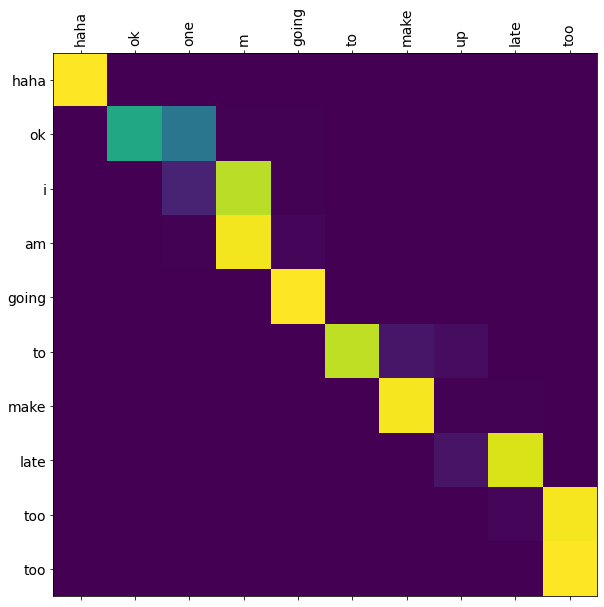

In [ ]:
result=translate("haha ok one m going to make up late too")

### Blue Score on validation data using Beam Search

In [ ]:
import nltk.translate.bleu_score as bleu
def BleuScore(validation):
    input=list(validation['NormalizedText'])
    Y_true=list(validation['Original_English_Text_out'])
    bleuscores=[]
    for i in range(len(input)):
        try:
            result, sentence, attention_plot = evaluate(input[i])
        except KeyError as e:
            pass  
    bleuscores.append(bleu.sentence_bleu(Y_true[i], result))
    return sum(bleuscores)/len(bleuscores)

AvearageScore=BleuScore(validation)

print("Avearage Bleuscore for concat score function :",AvearageScore)

Avearage Bleuscore for concat score function : 0.6887246539984299


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Steps Performed:

1.Extracted scoial media text data(normal text data) and original english data from the given source file

2.Used data agumentation using NLPAUG library and used two types of augmentation methods 1.Synonym Agumentation and 2.FastText agumentation for the words and generated nearly 4000 data points which then concatenated with source data points and overall data set size is 6000 points.

3.Preprocessed data using re module and removed all puntuation marks and other special symbols.

4.Created embedding weights using fastext model and used this weights in enbedding layer in neural network

5. Using Data generators trained encoder and decoder model and get the train accuracy 85% and test accuracy 60%

6. Trained one more neural network model using Bhendu attention mechanisam and it gives 95% train accuracy and 75% test accuracy.

7. The Average Blue score of the neural network using beam search is 68% and it is pretty good